In [1]:
NOTE = 'LightGBMベクトルは除外しBatterIDでGroupKFold'
notebook_name = '082'
CV = 'GroupK-Fold(batterID)'
group_col = 'batterID'

In [2]:
import json
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

082_submission.csv 082


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
groups = train[group_col]

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])
# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(12, 384, 107)

In [7]:
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [8]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [9]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [10]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [11]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [12]:
with open(os.path.join('001_EDA', f'group_kfold_{group_col}.json'), 'r') as f:
    fold = json.load(f)
fold

{'0': [313,
  229,
  140,
  340,
  118,
  335,
  321,
  151,
  624,
  183,
  239,
  111,
  184,
  295,
  60,
  82,
  127,
  132,
  572,
  303,
  182,
  311,
  276,
  72,
  55,
  185],
 '1': [349,
  91,
  496,
  443,
  121,
  5,
  105,
  73,
  391,
  535,
  149,
  12,
  412,
  0,
  196,
  509,
  193,
  114,
  582,
  574,
  58,
  2,
  462,
  224,
  26],
 '2': [22,
  556,
  47,
  444,
  9,
  646,
  523,
  449,
  601,
  217,
  201,
  374,
  84,
  402,
  557,
  381,
  261,
  330,
  150,
  135,
  492,
  70,
  628,
  203,
  498],
 '3': [644,
  220,
  148,
  253,
  168,
  27,
  271,
  392,
  192,
  39,
  368,
  485,
  87,
  145,
  619,
  333,
  264,
  36,
  480,
  355,
  98,
  432,
  34,
  164],
 '4': [328,
  636,
  85,
  269,
  362,
  18,
  112,
  555,
  661,
  138,
  475,
  21,
  654,
  500,
  80,
  565,
  510,
  416,
  37,
  153,
  559,
  479,
  293],
 '5': [620,
  446,
  417,
  226,
  263,
  171,
  427,
  199,
  642,
  15,
  488,
  130,
  540,
  418,
  45,
  458,
  67,
  191,
  537,
  301,

In [13]:
%%time
# splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
# for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
for str_i, ids in fold.items():
    i = int(str_i)
    mask = groups.isin(ids)  # training/validation = False/True
    train_idx, id_train, X_train, y_train, valid_idx, id_valid, X_valid, y_valid = (
        train[~mask].index,
        train[~mask].id,
        train[~mask][features],
        train[~mask].y,
        train[mask].index,
        train[mask].id,
        train[mask][features],
        train[mask].y,
    )
    # feature transformation
    ## categorical features
    """
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    """
    ## descrete features
    """
    discrete_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    ).fit(X_train.copy()[discrete_features])
    X_train_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_train.copy()[discrete_features]),
        columns=discrete_features,
        index=train_idx
    )
    X_valid_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_valid.copy()[discrete_features]),
        columns=discrete_features,
        index=valid_idx
    )
    X_test_discrete = pd.DataFrame(
        data=discrete_transformer.transform(test.copy()[discrete_features]),
        columns=discrete_features,
        index=test.index
    )
    discrete_transformer.feature_names__ = discrete_features
    discrete_transformer.input_features__ = discrete_features
    with open(os.path.join(OUTPUT_DIR, f'discrete_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(discrete_transformer, f)
        f.close()
    """
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = X_train[discrete_features + categorical_features]
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = X_valid[discrete_features + categorical_features]
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = test[discrete_features + categorical_features]
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    # classification    
    clf = LGBMClassifier(objective='multiclass',
                         importance_type='gain',
                         n_jobs=-1,
                         class_weight='balanced',
                         n_estimators=500,
                         learning_rate=0.01,
                         boosting_type='gbdt',
                         num_leaves=32,
                         random_state=SEED,
                         reg_alpha=0.05)
    clf.fit(X_train_transformed,
            y_train.values,
            categorical_feature=categorical_features,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 1)**********
[[2653  958  689  572  423  195    7  100]
 [ 465 2519  416  319  252  107    4   64]
 [ 267  276 1515  260  188   77    1   38]
 [ 114  119  105 1426   92   30    1    8]
 [   0    0    0    0  576    0    0    0]
 [   0    0    0    0    0  165    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 1)**********
[[222 309  51 151   3   0   0   0]
 [121 315  32  62   6   0   0   0]
 [ 92 137  39  99   3   0   0   0]
 [ 38  97  31  73   2   0   0   0]
 [ 24  40   8  27   0   0   0   0]
 [  1   9   4   8   0   0   0   0]
 [  2   0   0   0   0   0   0   0]
 [  1   9   0   3   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 2)**********
[[2694  951  683  604  435  169    7  105]
 [ 498 2530  424  352  248  106    3   64]
 [ 291  280 1517  291  191   61    1   34]
 [  97  123  105 1478   96   32    2    7]
 [   0    0    0    0  598    1    0    0]
 [   0    0    0    0    0  162    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 2)**********
[[197 292  54 136   6   0   0   0]
 [ 78 271  24  78   6   0   0   0]
 [ 48 131  25 121   1   0   0   0]
 [ 31  88  13  63   1   0   0   0]
 [ 17  32   5  21   1   0   0   0]
 [  6   8   1   9   1   0   0   0]
 [  0   0   0   1   0   0   0   0]
 [  5   4   1   2   1   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 3)**********
[[2694  942  691  602  448  182    6   96]
 [ 496 2483  437  348  264  100    2   50]
 [ 267  283 1533  287  199   69    2   34]
 [ 104  123  107 1457   98   31    1    6]
 [   0    0    0    0  608    1    0    0]
 [   0    0    0    0    0  165    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  106]]

**********Confusion matrix for validation set (Fold 3)**********
[[164 348  34 123   3   0   0   0]
 [ 93 306  25  75   1   0   2   0]
 [ 57 129  29 101   2   0   0   0]
 [ 42  87  17  61   2   0   0   0]
 [ 14  25   5  22   0   0   0   0]
 [  1  11   2   8   0   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  1   8   1   4   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 4)**********
[[2674  921  665  567  449  189    7   98]
 [ 495 2473  402  347  267   97    6   56]
 [ 272  280 1524  268  188   75    2   33]
 [  89  109  105 1454   97   34    1    4]
 [   0    0    0    0  603    0    0    0]
 [   0    0    0    0    0  161    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  102]]

**********Confusion matrix for validation set (Fold 4)**********
[[193 385  29 152   4   0   0   0]
 [111 309  23  94   2   0   0   0]
 [ 66 122  27 132   3   0   0   0]
 [ 51  96  23  70   3   0   0   0]
 [ 15  24   3  30   0   0   0   0]
 [  5   8   1  12   0   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  3   9   3   3   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 5)**********
[[2701  979  687  590  462  183    6   99]
 [ 487 2508  411  354  281  109    3   59]
 [ 295  290 1520  286  209   68    1   28]
 [  94  122  106 1450   95   29    2    6]
 [   0    0    0    0  619    1    0    0]
 [   0    0    0    0    0  169    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  105]]

**********Confusion matrix for validation set (Fold 5)**********
[[182 259  18 157  10   0   0   0]
 [ 92 260  18  96   4   0   0   0]
 [ 77 103  16  96   3   0   0   0]
 [ 51  93   7  80   1   0   0   0]
 [  8  19   1  27   0   0   0   0]
 [ 10   6   0   2   0   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  3   6   0   6   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 6)**********
[[2686  957  692  604  460  189    6   97]
 [ 493 2500  423  352  273   95    3   65]
 [ 290  293 1511  296  206   76    1   35]
 [ 101  116  108 1444   87   34    2    6]
 [   0    0    0    0  608    1    0    0]
 [   0    0    0    0    0  171    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

**********Confusion matrix for validation set (Fold 6)**********
[[189 288  31 131   3   0   0   0]
 [103 279  17  79   0   0   0   0]
 [ 67 102  18  95   2   0   0   0]
 [ 67  82   8  81   0   0   0   0]
 [  8  26   7  25   0   0   0   0]
 [  5   6   0   5   0   0   0   0]
 [  0   0   0   1   0   0   0   0]
 [  2   5   0   2   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 7)**********
[[2733  929  700  601  468  211    7   98]
 [ 500 2505  418  343  272  122    3   60]
 [ 282  294 1523  301  217   81    1   33]
 [ 112  118  109 1461  104   36    2    4]
 [   0    0    0    0  612    1    0    0]
 [   0    0    0    0    0  177    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

**********Confusion matrix for validation set (Fold 7)**********
[[149 260  38 136   3   0   0   0]
 [ 64 280  40  75   0   0   0   0]
 [ 58  78  21 101   2   0   0   0]
 [ 35  68  14  70   3   0   0   0]
 [ 14  20   8  20   0   0   0   0]
 [  3   3   2   2   0   0   0   0]
 [  0   0   0   1   0   0   0   0]
 [  3   2   0   4   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 8)**********
[[2747  953  720  580  461  194    5   93]
 [ 491 2536  422  340  266  103    4   58]
 [ 290  279 1543  288  204   75    3   32]
 [ 110  110  115 1435  103   28    3    6]
 [   0    0    0    0  606    1    0    0]
 [   0    0    0    0    0  171    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

**********Confusion matrix for validation set (Fold 8)**********
[[171 284  24 101   0   0   0   0]
 [105 264  27  65   1   0   0   0]
 [ 63 102  24  89   0   0   0   0]
 [ 60  85  11  68   2   0   0   0]
 [ 17  22   5  24   0   0   0   0]
 [  3   7   3   3   0   0   0   0]
 [  0   1   0   0   0   0   0   0]
 [  1   6   0   2   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 9)**********
[[2701  953  712  608  454  206    6   99]
 [ 483 2536  448  349  275  109    3   56]
 [ 278  279 1542  294  209   77    3   32]
 [ 116  127  112 1441   99   33    2    6]
 [   0    0    0    0  611    1    0    0]
 [   0    0    0    0    0  167    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 9)**********
[[180 258  31 121   4   0   0   0]
 [ 77 260  23  63   0   0   0   0]
 [ 46 129  14  88   1   0   0   0]
 [ 42  82  16  59   1   0   0   0]
 [ 15  22   5  20   1   0   0   0]
 [  4   9   1   6   0   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  3   7   2   1   0   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 10)**********
[[2766  994  722  621  462  212    5  102]
 [ 507 2568  428  374  277  107    3   62]
 [ 281  292 1542  307  217   79    3   38]
 [ 113  118  111 1486  102   33    2   10]
 [   0    0    0    0  626    1    0    0]
 [   0    0    0    0    0  175    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  113]]

**********Confusion matrix for validation set (Fold 10)**********
[[119 217  35  77   1   0   0   0]
 [ 66 205  24  61   0   0   0   0]
 [ 42  89  23  78   1   0   0   0]
 [ 36  56  17  52   0   0   0   0]
 [ 10  21   4  13   0   0   0   0]
 [  3   4   1   4   0   0   0   0]
 [  0   0   0   1   0   0   0   0]
 [  0   5   1   1   0   0   0   0]]

Wall time: 3min 34s


In [14]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,10.000000,10.000000
mean,0.564612,0.139686
std,0.004180,0.004367
min,0.559583,0.130200
25%,0.561618,0.137766
50%,0.563375,0.140853
75%,0.567047,0.141860
max,0.573135,0.144811


In [15]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,0,0,1
2,2,0,0,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17078,1434,2,3,1,10
17079,1435,3,3,1,10
17133,9762,1,1,1,10
17134,9763,2,1,1,10


In [16]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.200524,0.110686,0.370114,0.053692,0.258042,0.002938,0.001906,0.002097,27446,1
1,0.169249,0.294523,0.205556,0.305689,0.018094,0.001924,0.003508,0.001458,113,1
2,0.296615,0.477314,0.131982,0.083531,0.007277,0.001108,0.001547,0.000626,4479,1
3,0.348244,0.339672,0.138374,0.160411,0.009943,0.001201,0.001287,0.000868,29080,1
4,0.268779,0.155958,0.262230,0.181541,0.025809,0.100976,0.002494,0.002213,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.116105,0.396086,0.214875,0.266204,0.002631,0.001505,0.001470,0.001125,24272,10
33804,0.147370,0.234644,0.459526,0.139549,0.008691,0.003541,0.003784,0.002895,29106,10
33805,0.135250,0.215755,0.449238,0.180878,0.008580,0.004105,0.003509,0.002685,20679,10
33806,0.418622,0.173870,0.312034,0.082347,0.005919,0.002383,0.002733,0.002091,25901,10


In [17]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,2.394998,2.980727,2.354605,1.760864,0.428956,0.035979,0.024193,0.019678
1,1,3.063476,3.907864,1.056612,1.838333,0.048247,0.057577,0.015687,0.012204
2,2,0.470927,1.193527,1.321571,5.412720,1.406714,0.088772,0.024918,0.080850
3,3,3.410755,4.753600,0.929723,0.783325,0.094647,0.010443,0.009659,0.007848
4,4,1.772503,3.081801,0.464931,0.862207,3.794506,0.007821,0.008342,0.007888
...,...,...,...,...,...,...,...,...,...
33803,33803,4.820266,1.281334,1.680451,1.572614,0.574783,0.023102,0.019896,0.027553
33804,33804,3.063249,2.728280,1.369999,2.486608,0.311258,0.016073,0.013581,0.010951
33805,33805,4.563628,2.516363,0.848998,1.902133,0.126417,0.017265,0.012970,0.012227
33806,33806,0.955668,2.039323,3.397500,3.306154,0.153976,0.068441,0.043712,0.035227


In [18]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,4
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,2


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.274314
1    0.432767
2    0.078443
3    0.178508
4    0.023545
5    0.008105
6    0.000532
7    0.003786
Name: y, dtype: float64

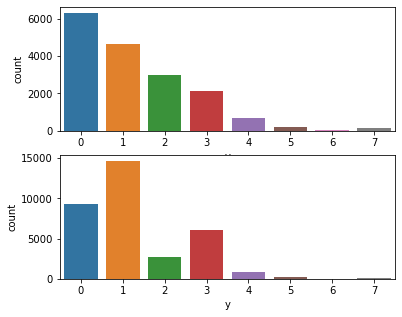

In [19]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [20]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [21]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.5646124152019485, 0.13968584842232293)

In [22]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"082_submission.csv","GroupK-Fold(batterID)","0.564612","0.139686","","LightGBMベクトルは除外しBatterIDでGroupKFold"


In [23]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 31.2 ms


In [24]:
imp_df

,feature,importance,fold
0,totalPitchingCount,69509.317964,1
1,B,36454.461450,1
2,S,48024.204979,1
3,O,25339.623830,1
4,inningNo,46013.758790,1
...,...,...,...
114,batterTeam,42.228330,10
115,pitcherTeam,53.763171,10
116,b1,3499.745000,10
117,b2,3011.283155,10


In [25]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=final_estimator.feature_names__)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [26]:
coef_df

""
